In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
from astropy.io import fits
from sklearn.tree import DecisionTreeRegressor
import glob
from astropy import units as u


In [2]:
#Glob away all the fits in a dir
fits_list =glob.glob("*.fits")
print(fits_list)

['spec-1678-53433-0001.fits', 'spec-1678-53433-0425.fits', 'spec-0548-51986-0020.fits', 'spec-0548-51986-0001.fits']


In [6]:
#Extra the fits tables from all the globbed fits
specdata_list=[]
for i in fits_list:
    with fits.open(i) as fit_file:
        specdata=fit_file[1].data
        header=fit_file[0].header
        specdata_list.append(specdata)

        

In [8]:
#Get the shapes of each spectra then find the smallest shape along 0 axis
spec_shape_list=[]
for i in specdata_list:
    print(i.shape)
    spec_shape_list.append(i.shape)

spec_shape_list=np.array(spec_shape_list)
smallest_spec=np.min(spec_shape_list)

(3822,)
(3846,)
(3828,)
(3769,)


In [9]:
#Performing filtering of the spectra along lambda axis as data is not recording properly from first lambda
#to last lambda, as in some spectra the measurements start from different first to different last lambda
spectra_filtered_list=[]
for i in specdata_list:
    spec=i
    #apply booleam mask along lambda axis from 3.562 to 3.957 lambdas
    mask = (spec.loglam >= 3.582) & (spec.loglam <= 3.957)
    filtered_data = spec[mask]
    spectra_filtered_list.append(filtered_data)
#And here we have a np array containing individual spectras
spectra_filtered_list=np.array(spectra_filtered_list)
spectra_filtered_list.shape

(4, 3751)

In [20]:

# Use the row index (fiber index) as the feature, and the spectra as the target
spectra_filtered_list_array=np.array(spectra_filtered_list['sky'])
indices= np.arange(spectra_filtered_list_array.shape[0]).reshape(-1,1)
#x_train, x_test=train_test_split(spectra_filtered_list_array, test_size=0.1, random_state=42)
tree =DecisionTreeRegressor()

tree.fit(indices, spectra_filtered_list_array) #tree.fit(features, targets)



DecisionTreeRegressor()

In [29]:
#Generate the master sky from prediction
master_sky=tree.predict( np.array(indices.shape[0]).reshape(-1,1))

In [71]:
#Subtract the master from one of the fibers to get residuals
sub=master_sky[0]- spectra_filtered_list[1]['sky']


#Convert to flux units
sub_flux = sub* 10**-17 * u.Unit('erg cm-2 s-1 AA-1') 
flux=spectra_filtered_list[1]['sky']* 10**-17 * u.Unit('erg cm-2 s-1 AA-1') 
master_sky_flux=master_sky[0]* 10**-17 * u.Unit('erg cm-2 s-1 AA-1') 

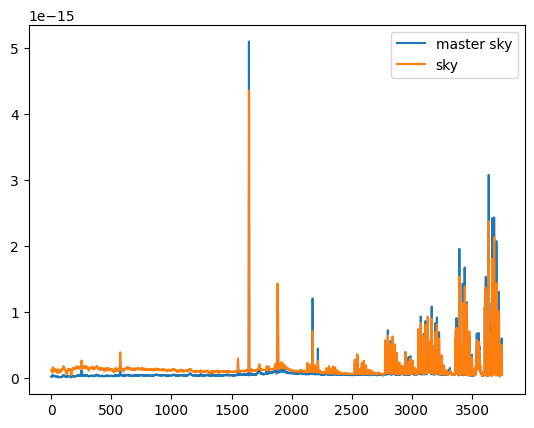

In [72]:
plt.plot(master_sky_flux, label='master sky')
plt.plot(flux, label='sky')
plt.legend()

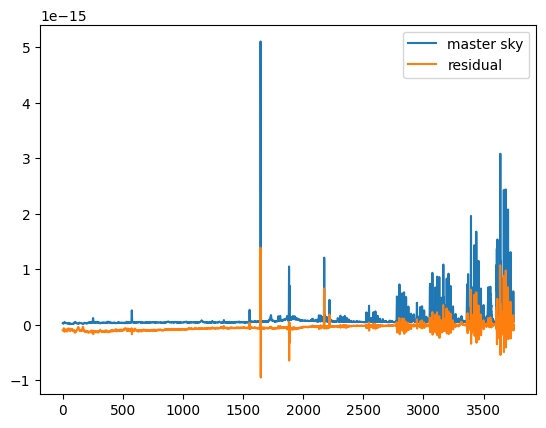

In [73]:
plt.plot(master_sky_flux, label='master sky')
plt.plot(sub_flux, label='residual')
plt.legend()

Text(0.5, 1.0, 'Effects of Decison Tree for master sky from 4 fibres')

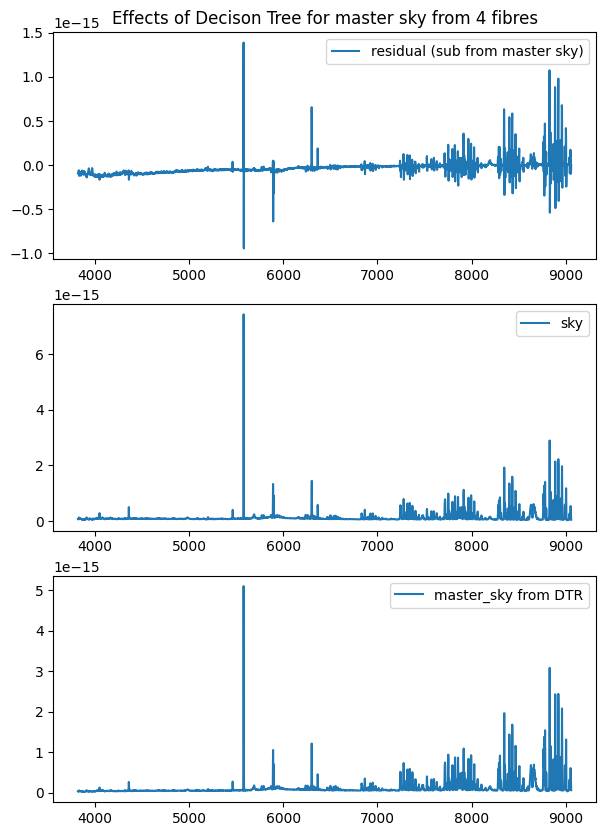

In [66]:


fig,ax=plt.subplots(nrows=3, figsize=(7,10))
ax[0].plot(10**spectra_filtered_list[1]['loglam'] * u.AA,sub_flux, label='residual (sub from master sky)')
ax[0].legend()
ax[1].plot(10**spectra_filtered_list[1]['loglam'] * u.AA, flux, label='sky')
ax[1].legend()
ax[2].plot(10**spectra_filtered_list[1]['loglam'] * u.AA, master_sky_flux, label='master_sky from DTR')
ax[2].legend()
ax[0].set_title('Effects of Decison Tree for master sky from {0} fibres'.format(spectra_filtered_list.shape[0]))


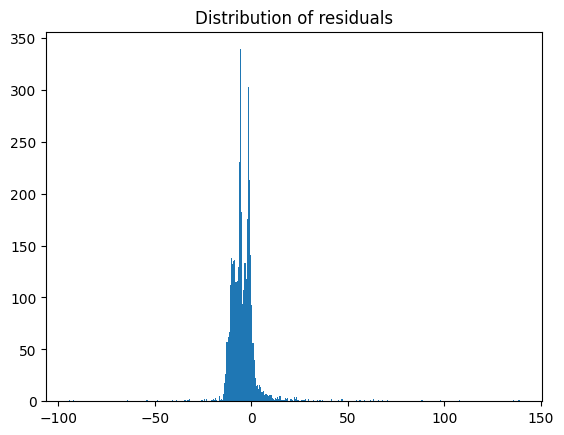

In [85]:

plt.hist(sub, bins=400)
plt.title('Distribution of residuals')
plt.show()